# S'all good, man

HACK3 hackathon 2023

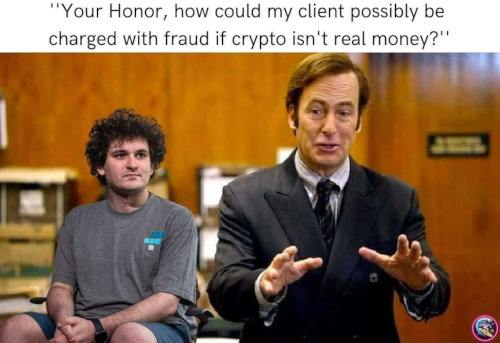

## Overview

Custom Q/A bot based on our provided data, OR your own custom text source input data

## Preparing the Colab Environment

- [Enable GPU Runtime](https://docs.haystack.deepset.ai/docs/enabling-gpu-acceleration#enabling-the-gpu-in-colab)


## Installing Haystack

To start, let's install the latest release of Haystack with `pip`:

In [ ]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab]

Set the logging level to INFO:

In [2]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## Initializing the ElasticsearchDocumentStore

A DocumentStore stores the Documents that the question answering system uses to find answers to your questions. Here, we're using the [`ElasticsearchDocumentStore`](https://docs.haystack.deepset.ai/reference/document-store-api#module-elasticsearch) which connects to a running Elasticsearch service. It's a fast and scalable text-focused storage option. This service runs independently from Haystack and persists even after the Haystack program has finished running. To learn more about the DocumentStore and the different types of external databases that we support, see [DocumentStore](https://docs.haystack.deepset.ai/docs/document_store).

1. Download, extract, and set the permissions for the Elasticsearch installation image:

In [3]:
%%bash

wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.9.2-linux-x86_64.tar.gz -q
tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz
chown -R daemon:daemon elasticsearch-7.9.2

2. Start the server:

In [4]:
%%bash --bg

sudo -u daemon -- elasticsearch-7.9.2/bin/elasticsearch

If you are working in an environment where Docker is available, you can also start Elasticsearch using Docker. You can do this manually, or using our [`launch_es()`](https://docs.haystack.deepset.ai/reference/utils-api#module-doc_store) utility function.

3. Wait 30 seconds for the server to fully start up:

In [5]:
import time
time.sleep(30)

4. Initialize the ElasticsearchDocumentStore:


In [6]:
from haystack.utils import launch_es
launch_es()

In [12]:
import os
from haystack.document_stores import ElasticsearchDocumentStore

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")

document_store = ElasticsearchDocumentStore(
    host=host,
    username="",
    password="",
    index="document"
)

os.makedirs("data/legal")

FileExistsError: ignored

ElasticsearchDocumentStore is up and running and ready to store the Documents.

## Indexing Documents with a Pipeline

The next step is adding the files to the DocumentStore. The indexing pipeline turns your files into Document objects and writes them to the DocumentStore. Our indexing pipeline will have two nodes: `TextConverter`, which turns `.txt` files into Haystack `Document` objects, and `PreProcessor`, which cleans and splits the text within a `Document`.

Once we combine these nodes into a pipeline, the pipeline will ingest `.txt` file paths, preprocess them, and write them into the DocumentStore.


1. Please place your extracted knowledge source (`data/legal/source_en.txt` in our repo) in the `data/legal` folder on the left navigation pane. 

In [13]:
doc_dir = "data/legal"

2. Initialize the pipeline, TextConverter, and PreProcessor:

In [14]:
from haystack import Pipeline
from haystack.nodes import TextConverter, PreProcessor

indexing_pipeline = Pipeline()
text_converter = TextConverter()
preprocessor = PreProcessor(
    clean_whitespace=True,
    clean_header_footer=True,
    clean_empty_lines=True,
    split_by="word",
    split_length=200,
    split_overlap=20,
    split_respect_sentence_boundary=True,
)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


To learn more about the parameters of the `PreProcessor`, see [Usage](https://docs.haystack.deepset.ai/docs/preprocessor#usage). To understand why document splitting is important for your question answering system's performance, see [Document Length](https://docs.haystack.deepset.ai/docs/optimization#document-length).

2. Add the nodes into an indexing pipeline. You should provide the `name` or `name`s of preceding nodes as the `input` argument. Note that in an indexing pipeline, the input to the first node is `File`.

In [15]:
import os

indexing_pipeline.add_node(component=text_converter, name="TextConverter", inputs=["File"])
indexing_pipeline.add_node(component=preprocessor, name="PreProcessor", inputs=["TextConverter"])
indexing_pipeline.add_node(component=document_store, name="DocumentStore", inputs=["PreProcessor"])


3. Run the indexing pipeline to write the text data into the DocumentStore:

In [16]:
files_to_index = [doc_dir + "/" + f for f in os.listdir(doc_dir)]
indexing_pipeline.run_batch(file_paths=files_to_index)

INFO:haystack.pipelines.base:It seems that an indexing Pipeline is run, so using the nodes' run method instead of run_batch.


Converting files:   0%|          | 0/1 [00:00<?, ?it/s]

Preprocessing:   0%|          | 0/1 [00:00<?, ?docs/s]

{'documents': [<Document: {'content': '2/2003 (III. 4.)FMM Decree amending Decree 21/1999 (IV. 28.)GM on the detailed rules for the use and management of the head-managed appropriations for the support of active employment objectives 1 16.05.2008 Act XXXVIII of 1992 on Public Finances Act No 24. §-Article 24(4) and Article 49(o) of the Act of 1992 on the Public Finances of the Republic of Hungary, in agreement with the Minister of Finance and after having heard the opinion of the Labour Market Fund Management Board, I hereby decree as follows: § 1-3 § 2 § 4 (1) This Decree shall enter into force on the day of its publication. (2) Where the Minister of Economy and the Minister of Economy are mentioned in the Minister of Employment and Labour Policy and the Minister of Employment and Labour Policy, they shall be understood to mean the Ministry of Employment and Labour. 1 The Decree was repealed by Section 25(2)(b) of Decree No 3/2012 (II. 10.)of the Ministry of Finance of the Republic of

The code in this project uses our own custom scraped legal data, but you can also supply your own `.txt` files and index them in the same way.

As an alternative, you can cast you text data into [Document objects](https://docs.haystack.deepset.ai/docs/documents_answers_labels#document) and write them into the DocumentStore using [`DocumentStore.write_documents()`](https://docs.haystack.deepset.ai/reference/document-store-api#basedocumentstorewrite_documents).

Now that the Documents are in the DocumentStore, let's initialize the nodes we want to use in our query pipeline.

## Initializing the Retriever

Our query pipeline is going to use a Retriever, so we need to initialize it. A Retriever sifts through all the Documents and returns only those that are relevant to the question. This tutorial uses the BM25Retriever. This is the recommended Retriever for a question answering system like the one we're creating. For more Retriever options, see [Retriever](https://docs.haystack.deepset.ai/docs/retriever).

In [17]:
from haystack.nodes import BM25Retriever

retriever = BM25Retriever(document_store=document_store)

The BM25Retriever is initialized and ready for the pipeline.

## Initializing the Reader

Our query pipeline also needs a Reader, so we'll initialize it next. A Reader scans the texts it received from the Retriever and extracts the top answer candidates. Readers are based on powerful deep learning models but are much slower than Retrievers at processing the same amount of text. This tutorials uses a FARMReader with a base-sized RoBERTa question answering model called [`deepset/roberta-base-squad2`](https://huggingface.co/deepset/roberta-base-squad2). It's a good all-round model to start with. To find a model that's best for your use case, see [Models](https://docs.haystack.deepset.ai/docs/reader#models).

In [18]:
from haystack.nodes import FARMReader

reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2", use_gpu=True)

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)


INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.


INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


## Creating the Retriever-Reader Pipeline

You can combine the Reader and Retriever in a querying pipeline using the `Pipeline` class. The combination of the two speeds up processing because the Reader only processes the Documents that it received from the Retriever. 

Initialize the `Pipeline` object and add the Retriever and Reader as nodes. You should provide the `name` or `name`s of preceding nodes as the input argument. Note that in a querying pipeline, the input to the first node is `Query`.

In [19]:
from haystack import Pipeline

querying_pipeline = Pipeline()
querying_pipeline.add_node(component=retriever, name="Retriever", inputs=["Query"])
querying_pipeline.add_node(component=reader, name="Reader", inputs=["Retriever"])


That's it! Your pipeline's ready to answer your questions!

## Asking a Question

To ask a new question, you have to run this 1st cell here, but not the ones before it. To get the answer, run the 2nd and/or 3rd step here as well. 

1. Use the pipeline's `run()` method to ask a question. The query argument is where you type your question. Additionally, you can set the number of documents you want the Reader and Retriever to return using the `top-k` parameter. To learn more about setting arguments, see [Arguments](https://docs.haystack.deepset.ai/docs/pipelines#arguments). To understand the importance of the `top-k` parameter, see [Choosing the Right top-k Values](https://docs.haystack.deepset.ai/docs/optimization#choosing-the-right-top-k-values).


In [20]:
prediction = querying_pipeline.run(
    query="As an employer, what do I have to take care of if I have workers in an explosive atmosphere, as required by the explosion protection documentation in § 9?",
    params={
        "Retriever": {"top_k": 10},
        "Reader": {"top_k": 5}
    }
)

INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manually. This might cause a mismatch with the ID that would be generated from the document content and id_hash_keys value.
INFO:haystack.schema:Setting the ID manu

Inferencing Samples:   0%|          | 0/1 [00:00<?, ? Batches/s]

Here are some questions you could try out:
- Who is the father of Arya Stark?
- Who created the Dothraki vocabulary?
- Who is the sister of Sansa?

2. Print out the answers the pipeline returns (optional):

In [21]:
from pprint import pprint

pprint(prediction)

{'answers': [<Answer {'answer': 'supervision', 'type': 'extractive', 'score': 0.7366992831230164, 'context': 'orkers or persons. §-(4) If the worker is in an explosive atmosphere, supervision shall be provided for the duration of the work in accordance with th', 'offsets_in_document': [{'start': 377, 'end': 388}], 'offsets_in_context': [{'start': 70, 'end': 81}], 'document_id': '71c666d224f560b3bc24ac1e622b80c2', 'meta': {'_split_id': 24}}>,
             <Answer {'answer': 'appropriate training', 'type': 'extractive', 'score': 0.5048122406005859, 'context': 'oyer shall provide workers working in explosive atmospheres with appropriate training in explosion protection. § (a) work in potentially explosive atm', 'offsets_in_document': [{'start': 531, 'end': 551}], 'offsets_in_context': [{'start': 65, 'end': 85}], 'document_id': 'ed767046ddc4f1ff60d186e5143545ee', 'meta': {'_split_id': 23}}>,
             <Answer {'answer': 'to prevent the connecting equipment from being replaced by non-com

3. Simplify the printed answers:

In [22]:
from haystack.utils import print_answers

print_answers(
    prediction,
    details="medium" ## Choose from `minimum`, `medium` and `all`
)


Query: As an employer, what do I have to take care of if I have workers in an explosive atmosphere, as required by the explosion protection documentation in § 9?
Answers:
[   {   'answer': 'supervision',
        'context': 'orkers or persons. §-(4) If the worker is in an explosive '
                   'atmosphere, supervision shall be provided for the duration '
                   'of the work in accordance with th',
        'score': 0.7366992831230164},
    {   'answer': 'appropriate training',
        'context': 'oyer shall provide workers working in explosive '
                   'atmospheres with appropriate training in explosion '
                   'protection. § (a) work in potentially explosive atm',
        'score': 0.5048122406005859},
    {   'answer': 'to prevent the connecting equipment from being replaced by '
                  'non-compliant equipment',
        'context': ' source. The employer must take the necessary protective '
                   'measures to prevent

And there you have it! Congratulations on building a scalable machine learning based question answering system!

# Next Steps

To learn how to improve the performance of the Reader, see [Fine-Tune a Reader](https://haystack.deepset.ai/tutorials/02_finetune_a_model_on_your_data).

## Source

This notebook was made based on a [Haystack](https://github.com/deepset-ai/haystack/) notebook which made with love by [deepset](https://deepset.ai/) in Berlin, Germany